# Study to replicate

This notebook identifies PPMI subjects to reproduce the following paper:


<div class="alert alert-block alert-success">
Scherfler, Christoph, et al. <a href=https://onlinelibrary.wiley.com/doi/pdf/10.1002/ana.22245>White and gray matter abnormalities in idiopathic rapid eye movement sleep behavior disorder: a diffusion‐tensor imaging and voxel‐based morphometry study.</a> Annals of neurology 69.2 (2011): 400-407. 
</div>

This study recruited 34 patients with iRBD and confirmed iRBD diagnosis with polysomnography. Patients had no PD or dementia at time of MRI. The demographics parameters were as follows (table extracted from the paper):

<img src="images/demographics.png"/>

The main results of the paper regarding structural MRI is that Voxel-Based Morphometry (VBM) reveals an increase of gray matter density in both hippocampi of iRBD patients, as illustrated in the following table extracted from the paper (diffusion MRI results are truncated):

<img src="images/results.png" width=800/>

The remainder of this notebook is an attempt to replicate this result using the PPMI dataset.

# Initial setup

LivingPark notebooks use a *cache* directory to store analysis inputs and outputs. Inputs typically include PPMI Study Data and imaging data whereas outputs include processed images and other derivatives. Cache directories allow LivingPark notebooks to run in a few minutes as they reuse previously computed results. However, cache directories cannot be made public due to the PPMI Data Usage Agreement (DUA). Instead, they are stored on `login.bic.mni.mcgill.ca`, which requires a specific user name and password as well as a properly-configured DataLad installation in your account (see instructions [here](https://docs.google.com/document/d/1K7RzQjYC1O6tpSqe_c0CvxvJq38J10zNrDIdw20Yh_0/edit?usp=sharing)). In case you don't have access to the cache directory of this notebook, the next sections will download all the required imaging data from PPMI and recompute the results, which will take a few hours depending on your computer configuration. In the future, we will aim at storing this cache dataset on PPMI servers so that they can be accessed with a PPMI account.

Let's initialize the cache directory:

In [1]:
import livingpark_utils

utils = livingpark_utils.LivingParkUtils("scherfler-etal")
utils.prologue()

Installing notebook dependencies (see log in install.log)... 
This notebook was run on 2022-07-15 15:42:33.692355


# PPMI cohort preparation

We will build a PPMI cohort that matches the one used in the original study (Table 1) as much as possible. As in other LivingPark replications, we will use the same sample size as the original study. Our cohort will be built directly from PPMI Study Data files so that it can be replicated and updated whenever necessary.

## Study data download

We will start by downloading the PPMI Study Data files required to build our cohort: 
* Age at visit (this could also be retrieved from imaging data)
* Demographics (to retrieve sex)
* REM Sleep Behavior Disorder Questionnaire

We will use the LivingPark utils library to download these files from the notebook. If files are already present in the notebook cache, they won't be downloaded again. Otherwise, you will need to enter your PPMI username and password. In case you don't have a PPMI account, you can request one [here](http://ppmi-info.org).

In [2]:
required_files = [
    "Age_at_visit.csv",
    "Demographics.csv",
    "REM_Sleep_Behavior_Disorder_Questionnaire.csv",
]

utils.install_ppmi_study_files(required_files)

The following files are now available: ['Age_at_visit.csv', 'Demographics.csv', 'REM_Sleep_Behavior_Disorder_Questionnaire.csv']


We will also need file `MRI_info.csv` produced by another LivingPark notebook available at https://github.com/LivingPark-MRI/ppmi-MRI-metadata. This file contains a list of T1-weighted MRIs usable for VBM. 

In [3]:
# TODO: move this to livingpark_utils
import os.path as op

file_path = op.join(utils.study_files_dir, "MRI_info.csv")
if not op.exists(file_path):
    !(cd {utils.study_files_dir} && python -m wget "https://raw.githubusercontent.com/LivingPark-MRI/ppmi-MRI-metadata/main/MRI metadata.ipynb")  # use requests to improve portability
    npath = op.join(utils.study_files_dir, "MRI metadata.ipynb")
    %run "{npath}"
print(f"File {file_path} is now available")

File inputs/study_files/MRI_info.csv is now available


## RBD Score computation

The original study used polysomnography to diagnose REM Sleep Behavior Disorder, which is not available in PPMI.
Instead, we will use the REM Sleep Behavior Disorder Screening Questionnaire (RSBDSQ) [[1]](https://movementdisorders.onlinelibrary.wiley.com/doi/10.1002/mds.21740) to discriminate RBD patients from controls. This questionnaire consists of 13 yes/no questions that are summed to produce an RBD score. We computed the RBD score by summing the answers to each of the 13 questions. The answers to questions Q1 to Q9 (12 questions as Q6 is sub-divided in 4 parts) are directly availble in the RSBDSQ Study Data file. We computed the answer to Q10 ("I have/had a disease of the nervous system (e.g., stroke, head trauma, parkinsonism, RLS, narcolepsy, depression, epilepsy, inflammatory disease of the brain), which?") by taking the max of the 8 corresponding disease variables in the RSBDSQ Study Data file. We also computed the answer to Q6 as the sum of Q6.1 to Q6.4 as it will use as inclusion criterion for controls.

We obtain the following distribution of RBD scores in the PPMI dataset:

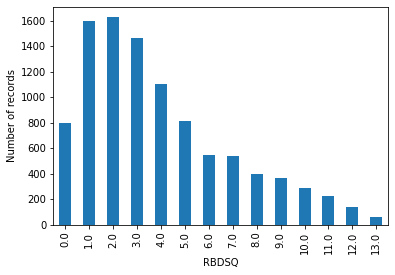

In [4]:
import pandas as pd

# Load PPMI RSBDQ data
df = pd.read_csv(
    op.join(utils.study_files_dir, "REM_Sleep_Behavior_Disorder_Questionnaire.csv")
)

# Compute RBDSQ score
df["RBDSQ"] = (
    df["DRMVIVID"]  # Q1
    + df["DRMAGRAC"]  # Q2
    + df["DRMNOCTB"]  # Q3
    + df["SLPLMBMV"]  # Q4
    + df["SLPINJUR"]  # Q5
    + df["DRMVERBL"]  # Q6.1
    + df["DRMFIGHT"]  # Q6.2
    + df["DRMUMV"]  # Q6.3
    + df["DRMOBJFL"]  # Q6.4
    + df["MVAWAKEN"]  # Q7
    + df["DRMREMEM"]  # Q8
    + df["SLPDSTRB"]  # Q9
    + df[  # Q10
        [
            "BRNINFM",
            "DEPRS",
            "EPILEPSY",
            "HETRA",
            "NARCLPSY",
            "PARKISM",
            "RLS",
            "STROKE",
        ]
    ].max(axis=1)
)

df["Q6"] = df["DRMVERBL"] + df["DRMFIGHT"] + df["DRMUMV"] + df["DRMOBJFL"]

# Note: CNSOTHCM isn't present in data

# Check that max RBDSQ score is <= 13
assert df["RBDSQ"].max() <= 13

df.groupby("RBDSQ").count()["REC_ID"].plot.bar()

from matplotlib import pyplot as plt

plt.ylabel("Number of records")
plt.show()

## Inclusion criteria

Consistently with the original study, we only include subjects with no Parkinsonism. For these subjects, we include all the visits that have a T1-weighted MRI usable for VBM (see [MRI metadata notebook](https://github.com/LivingPark-MRI/ppmi-MRI-metadata)).  We include subjects in the RBD group when their RBD score is >= 5. We include subjects in the control group when their RBD score is < 5 and their score to Q6 of the RSBDSQ is 0 [**TODO** ref needed, see email thread between Madeleine and Ron Postuma]. In case multiple visits of a given subject are included in the RBD of Control group, we randomly select one of them for inclusion in the group and exclude the other ones. This selection ensures that a given subject is included at most once in the RBD group and at most once in the control group. In Section "Cohort matching", we will ensure that a given subjet is included in at most one group. 

We obtain the following group sizes:

<!-- and a cutoff score of 6 to identify RBD subjects among PD subjects, consistently with the results presented in [[2]](https://www.sciencedirect.com# /science/article/pii/S138994571100164X). -->

In [5]:
# Read demographics and MRI data.
mri = pd.read_csv(op.join(utils.study_files_dir, "MRI_info.csv"))[
    ["Subject ID", "Visit code", "Description"]
]
mri.rename(columns={"Subject ID": "PATNO", "Visit code": "EVENT_ID"}, inplace=True)
dem = pd.read_csv(op.join("data", "Demographics.csv"))[["PATNO", "SEX"]]
age = pd.read_csv(op.join("data", "Age_at_visit.csv"))

# Merge RBD data with demographics, age and MRI
merged = (
    df.merge(dem, on="PATNO", how="inner")
    .merge(age, on=["PATNO", "EVENT_ID"], how="inner")
    .merge(mri, on=["PATNO", "EVENT_ID"], how="inner")[
        ["PATNO", "EVENT_ID", "RBDSQ", "Q6", "SEX", "AGE_AT_VISIT", "Description"]
    ]
)

# Extract RBD subjects and controls according to inclusion criteria
# Sample one entry (event and T1 description) per subject in each group so that a subject happens at most once in a group (between-group consistency will be ensured in cohort matching)
# Sort entries by PATNO to improve reproducibility of this notebook
rbds = (
    merged[merged["RBDSQ"] >= 5]
    .groupby("PATNO")
    .sample(1, random_state=1)
    .sort_values(by="PATNO")
)
controls = (
    merged[(merged["RBDSQ"] < 5) & (merged["Q6"] == 0)]
    .groupby("PATNO")
    .sample(1, random_state=1)
    .sort_values(by="PATNO")
)

print(f"Number of RBD subjects: {len(rbds)}")
print(f"Number of control subjects: {len(controls)}")

Number of RBD subjects: 415
Number of control subjects: 580


## Cohort matching

The RBD and Control groups built previously give us a lot of flexibility to build a cohort that matches the one in the original study, due to their large sample size compared to the original cohort. We adopted the following approach to construct a matching cohort:
1. Randomly select 4 control women and 10 control men, to reproduce the F/M balance in the original study
2. Find 26 subjects from the RBD group that best match age and sex in the selected control group. We matched sex by direct sampling of males and females using the same proportion as in the original study. We matched age using a nearest-neighbor approach.

We obtain the following cohort:

In [6]:
def nn_match(sample1, df_2, n2, cat_variables, num_variables, random_state=0):
    """
    Find len(sample1) rows in df_2 such that variables are matched with sample1.

    sample1: samples in group1
    df_2: dataframe with subjects in group 2
    n2: desired sample size for group 2
    cat_variables: categorical variables to match
    num_variables: numerical variables to match
    """

    def nn(x, df, variables):
        """
        Find index of nearest neighbor of x in df

        * x: a dataframe row
        * df: a dataframe
        * variables: variables to match. Should be normalized.
        """
        df["dist"] = sum((df[var] - x[var]) ** 2 for var in variables)
        df.sort_values("dist", inplace=True)
        return df.head(1).index[
            0
        ]  ## there's probably a better way to do it but it works

    # Check assumptions
    n1 = len(sample1)
    assert n1 <= n2
    for v in num_variables + cat_variables:
        assert v in sample1 and v in df_2

    # Copy original dataframe to leave them untouched
    df_2_ = df_2.copy()
    sample1_ = sample1.copy()

    # Normalize variables to match to compute meaningful distances
    for v in num_variables:
        m = df_2_[v].mean()
        s = df_2_[v].std()
        for df in (df_2_, sample1_):
            df[v] = (df[v] - m) / s

    # For each subject in sampled group 1,
    # find one or more subject in sampled group 2, without replacement.
    indices = []
    for i in range(n2):
        j = i % n1  # loop over sample1
        df_2_cat = df_2_.copy()
        for c in cat_variables:
            df_2_cat = df_2_cat[df_2_cat[c] == sample1_.iloc[j][c]]
        assert len(df_2_cat) > 0
        index = nn(sample1_.iloc[j], df_2_cat, num_variables)
        df_2_.drop(index=index, inplace=True)
        indices.append(index)

    sample2 = df_2[df_2.index.isin(indices)]

    return sample2

In [7]:
# Randomly select 4 control women and 10 control men, to reproduce F/M balance in original paper
controls = pd.concat(
    [
        controls[controls["SEX"] == 0].sample(n=4, random_state=1),
        controls[controls["SEX"] == 1].sample(n=10, random_state=1),
    ]
)

# Match with RBD subjects
rbds = nn_match(controls, rbds, 26, ["SEX"], ["AGE_AT_VISIT"], random_state=1)

In [8]:
import os

print(
    "\t\t\t| iRBD Patients\t| Controls"
    + os.linesep
    + f"Subjects, No. \t\t| {len(rbds)} \t\t| {len(controls)}"
    + os.linesep
    + f"F/M, No. \t\t| {len(rbds[rbds['SEX']==0])}/{len(rbds[rbds['SEX']==1])} \t\t| {len(controls[controls['SEX']==0])}/{len(controls[controls['SEX']==1])}"
    + os.linesep
    + f"Age, mean +/- SD \t| {round(rbds['AGE_AT_VISIT'].mean(),1)} +/- {round(rbds['AGE_AT_VISIT'].std(),1)} \t| {round(controls['AGE_AT_VISIT'].mean(),1)} +/- {round(controls['AGE_AT_VISIT'].std(),1)}"
)

			| iRBD Patients	| Controls
Subjects, No. 		| 26 		| 14
F/M, No. 		| 8/18 		| 4/10
Age, mean +/- SD 	| 59.1 +/- 10.6 	| 59.7 +/- 10.7


The demographics parameters of the selected PPMI subjects seem comparable to the ones in the initial study. 

Let's do basic sanity checks in this cohort:
* A subject appears at most once in each group
* A subject does not appear in more than one group

In [9]:
assert len(pd.unique(rbds["PATNO"])) == len(
    rbds
), "Some subjects are present more than once in RBD group"
assert len(pd.unique(controls["PATNO"])) == len(
    controls
), "Some subjects are present more than once in controls"
assert (
    len(set(controls["PATNO"]) & set(rbds["PATNO"])) == 0
), "Some subjects are present in controls and rbd group"
print("All sanity checks passed.")

All sanity checks passed.


In [10]:
# Concatenate both groups in cohort DataFrame
rbds["group"] = "RBD"
controls["group"] = "Control"
cohort = pd.concat([rbds, controls])

Finally, we generate a cohort id that uniquely identifies the cohort built previously. We will use this id to avoid recomputing the same results multiple times:

In [11]:
cohort_id = str(hash(tuple(sorted(cohort["PATNO"])))).replace(
    "-", "_"
)  # - in filenames crash SPM (Matlab)
print(f"Cohort id: {cohort_id}")

Cohort id: _3913746513060334940


In [12]:
# Save patient ids
filename = f"scherfler-etal-patnos-{cohort_id}.csv"
cohort["PATNO"].to_csv(filename, index=False)
print(f"Cohort patient ids saved in {filename}. Do not share this file publicly!")

Cohort patient ids saved in scherfler-etal-patnos-_3913746513060334940.csv. Do not share this file publicly!


# Image analysis

Structural MRI analysis in the original paper is a straightforward VBM analysis implemented with SPM using the DARTEL toolbox. To replicate it, we mostly followed the excellent tutorial on VBM in SPM available at https://www.fil.ion.ucl.ac.uk/~john/misc/VBMclass15.pdf

## Imaging data download

Let us first check if the Nifti image files associated with the subjects and visits selected in our cohort are available in cache:

In [13]:
import glob

cohort["File name"] = cohort.apply(
    lambda x: utils.find_nifti_file_in_cache(
        x["PATNO"], x["EVENT_ID"], x["Description"]
    ),
    axis=1,
)
print(f"Number of available subjects: {len(cohort[cohort['File name'].notna()])}")
print(f"Number of missing subjects: {len(cohort[cohort['File name'].isna()])}")

Number of available subjects: 40
Number of missing subjects: 0


We will now download the missing image files and move them to the data cache:

In [14]:
from ppmi_downloader import PPMIDownloader

ppmi_dl = PPMIDownloader()

missing_subject_ids = cohort[cohort["File name"].isna()]["PATNO"]
print(f"Downloading image data of {len(missing_subject_ids)} subjects")
ppmi_dl.download_imaging_data(
    missing_subject_ids,
    type="nifti",
    timeout=120 * len(missing_subject_ids),
    headless=False,
)

In [15]:
from ppmi_downloader import PPMINiftiFileFinder
import os

results_path = "outputs"

ppmi_fd = PPMINiftiFileFinder()

import pandas as pd

for _, row in cohort.iterrows():
    if row["File name"] is None:
        filename = ppmi_fd.find_nifti(row["PATNO"], row["EVENT_ID"], row["Description"])
        if filename is None:
            print(f"Not found: {row['PATNO'], row['EVENT_ID'], row['Description']}")
        else:  # copy file to dataset
            dest_dir = op.join(
                dataset_name, f'sub-{row["PATNO"]}', f'ses-{row["EVENT_ID"]}', "anat"
            )
            os.makedirs(dest_dir, exist_ok=True)
            os.rename(filename, op.join(dest_dir, op.basename(filename)))

In [16]:
cohort["File name"] = cohort.apply(
    lambda x: utils.find_nifti_file_in_cache(
        x["PATNO"], x["EVENT_ID"], x["Description"]
    ),
    axis=1,
)

In [17]:
# Link input file to results dir because SPM writes next to input files
for file_name in cohort["File name"].values:
    dest_dir = op.dirname(file_name).replace(
        op.join(utils.data_cache_path, "inputs"),
        op.join(results_path, "pre_processing"),
    )
    dest_file = op.join(dest_dir, op.basename(file_name))
    if not op.exists(dest_file):
        os.makedirs(dest_dir, exist_ok=True)
        os.symlink(op.relpath(op.abspath(file_name), start=dest_dir), dest_file)

## Image processing

Image processing consists of:
1. Data pre-processing: segmentation, DARTEL template generation, normalization to MNI space
2. Intra-cranial volume computation (to be used as covariates in the statistical model)
3. Statistical model

We implemented each of these steps as an SPM batch. For each batch, we created a template where file names will be inserted. Batch templates are available in `code/templates`.

### Pre-processing

We used the default parameters in SPM Segment, DARTEL, and Normalize to MNI Space modules, except for the Gaussian smoothing kernel size (FWHM) in the Normalise module that we set to 4 mm $\times$ 4 mm $\times$ 4 mm consistently with the original study. Our pre-processing batch template is in `code/templates/pre_processing_job.m`.

We will now add our cohort subjects to the pre-processing batch template:

In [18]:
import tempfile
import datalad.api as dat


def write_batch_files(batch_job_filename, replaced_keys, tempfile_name):
    """
    tempfile_name: should end in _job.m
    """

    def replace_keys(string, replace_keys):
        for k in replace_keys:
            string = string.replace(k, replace_keys[k])
        return string

    # Batch job file
    with open(batch_job_filename, "r") as f:
        content = f.read()

    assert tempfile_name.endswith("_job.m")

    with open(tempfile_name, "w") as f:
        f.write(replace_keys(content, replaced_keys))

    print(f"Job batch file written in {op.basename(tempfile_name)}")

    # Batch file
    batch_file = op.join("code", "templates", "call_batch.m")
    tempfile_name_batch = tempfile_name.replace("_job", "_batch")

    with open(batch_file, "r") as f:
        content = f.read()

    with open(tempfile_name_batch, "w") as f:
        f.write(
            replace_keys(
                content,
                {
                    "[BATCH]": f"addpath('{op.join(os.getcwd(), 'code', 'batches')}')"
                    + os.linesep
                    + op.basename(tempfile_name.replace(".m", ""))
                },
            )
        )

    print(f"Batch file written in {op.basename(tempfile_name_batch)}")


def run_batch_file(job_filename):

    log_file_name = op.abspath(
        op.join(
            results_path, "logs", op.basename(job_filename.replace("_job.m", ".log"))
        )
    )
    spm_batch_file = job_filename.replace("_job", "_batch")

    if op.exists(log_file_name):
        print(
            f"Log file {op.basename(log_file_name)} exists, skipping batch execution (remove file to force execution)"
        )
        return

    print(f"Log file {op.basename(log_file_name)} does not exist, running batch")

    output = spm_batch(
        "launch", "-s", "-u", spm_batch_file=spm_batch_file, log_file_name=log_file_name
    )

    assert (
        output.exit_code == 0
    ), f"Execution error, inspect output object for logs: {output}"

    print(f"Execution was successful.")

    return output

In [19]:
import glob

# Preprocessing batch
preprocessing_batch_job = op.join("code", "templates", "pre_processing_job.m")
preprocessing_name = op.abspath(
    op.join("code", "batches", f"pre_processing_{cohort_id}_job.m")
)

image_files = sorted(
    [
        op.abspath(
            utils.find_nifti_file_in_cache(
                row["PATNO"],
                row["EVENT_ID"],
                row["Description"],
                base_dir=op.join("outputs", "pre_processing"),
            )
        )
        for index, row in cohort.iterrows()
    ]
)
image_files_quote = [f"'{x},1'" for x in image_files]
write_batch_files(
    preprocessing_batch_job,
    {"[IMAGES]": os.linesep.join(image_files_quote)},
    tempfile_name=preprocessing_name,
)

Job batch file written in pre_processing__3913746513060334940_job.m
Batch file written in pre_processing__3913746513060334940_batch.m


We can now run the pre-processing batch. To ensure that it will run on this computer, we containerized it with Docker and wrapped it in a Boutiques descriptor. Let's run the batch. If it's the first time that you run this notebook, the Docker container will be downloaded to your computer:

In [20]:
d = dat.Dataset(utils.data_cache_path)

dat.unlock(
    dataset=d
)  # unlock the dataset so that results can be overwritten if necessary

[INFO] Unlocking files 
[INFO] Completed unlocking files 


[]

In [21]:
# Directory creations

for d in ["logs", "results"]:
    os.makedirs(op.join(results_path, d), exist_ok=True)

In [22]:
# Boutiques initialization for SPM batch
from boutiques.descriptor2func import function

spm_batch = function(
    op.join("envs", "docker", "spm-batch.json")
)  # Use Octave 5.2.0 for DARTEL or it crashes

output = run_batch_file(preprocessing_name)

Log file pre_processing__3913746513060334940.log exists, skipping batch execution (remove file to force execution)


### Intra-cranial volume computation

We compute intra-cranial volumes by (1) computing tissue volumes using the corresponding tool in SPM, (2) summing the grey-matter, white-matter, and CSF volumes. 

First, let's run the tissue volumes batch:

In [23]:
# Tissue volumes batch
tissue_volumes_batch_job = op.join("code", "templates", "tissue_volumes_job.m")
volumes_name = preprocessing_name.replace("pre_processing", "tissue_volumes")

segmentation_files = sorted(
    [x.replace(".nii", "_seg8.mat").replace(",1", "") for x in image_files]
)
volumes_file = op.abspath(
    op.join(results_path, op.basename(volumes_name.replace(".m", ".txt")))
)  # output file containing brain volumes
write_batch_files(
    tissue_volumes_batch_job,
    {
        "[SEGMENTATION_FILES]": os.linesep.join([f"'{x}'" for x in segmentation_files]),
        "[VOLUMES_FILE]": volumes_file,
    },
    tempfile_name=volumes_name,
)
output = run_batch_file(volumes_name)

Job batch file written in tissue_volumes__3913746513060334940_job.m
Batch file written in tissue_volumes__3913746513060334940_batch.m
Log file tissue_volumes__3913746513060334940.log exists, skipping batch execution (remove file to force execution)


We obtain the following distribution of intra-cranial volumes:

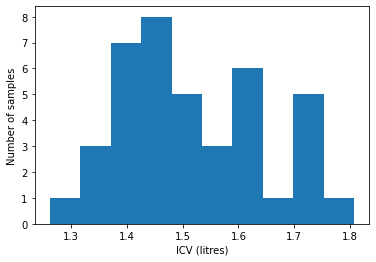

In [24]:
# Read tissue volumes file

import csv

icvs = {}  # intra-cranial volumes per segmentation file


def subject_id(segmentation_filename):
    """
    Return subject id from segmentation file name
    """

    sub_id = segmentation_filename.split(op.sep)[-4].replace("sub-", "")
    assert int(sub_id)
    return sub_id


with open(volumes_file) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        assert len(row) == 4, f"Malformed row: {row}"
        icvs[subject_id(row["File"])] = (
            float(row["Volume1"]) + float(row["Volume2"]) + float(row["Volume3"])
        )

plt.hist([icvs[x] for x in icvs])
plt.xlabel("ICV (litres)")
plt.ylabel("Number of samples")
plt.show()

## Statistical analysis

**TODO** [ADD description here, include FWE threshold, contrasts]

In [25]:
spm_batch = function(op.join("envs", "docker", "spm-batch.json"))

### Grey matter

In [26]:
# Stats batch (grey matter)
stats_batch_job = op.join("code", "templates", "stats_job.m")
stats_name = preprocessing_name.replace("pre_processing", "stats")

design_dir = op.join(results_path, "results-grey-matter")
os.makedirs(design_dir, exist_ok=True)


def smwc_scan(tissue_class, patno, visit, protocol_description):
    if not tissue_class in (1, 2):
        raise Exception(f"Unrecognized tissue class: {tissue_class}")
    expression = f"{op.join(results_path, 'pre_processing')}/sub-{patno}/ses-{visit}/anat/smwc{tissue_class}PPMI*{utils.clean_protocol_description(protocol_description)}*.nii"
    files = glob.glob(expression)
    assert (
        len(files) == 1
    ), f"Zero or more than 1 files were matched by expression: {expression}"
    return op.abspath(files[0])


# Don't mess up with ordering, it's critical
rbds_smwc1 = [
    f"'{smwc_scan(1, patno, rbds[rbds['PATNO']==patno]['EVENT_ID'].values[0],rbds[rbds['PATNO']==patno]['Description'].values[0])},1'"
    for patno in sorted(rbds["PATNO"])
]
controls_smwc1 = [
    f"'{smwc_scan(1, patno, controls[controls['PATNO']==patno]['EVENT_ID'].values[0], controls[controls['PATNO']==patno]['Description'].values[0])},1'"
    for patno in sorted(controls["PATNO"])
]

groups_patnos = [x for group in (rbds, controls) for x in sorted(group["PATNO"])]

# Check orderding
for i, x in enumerate(groups_patnos):
    if i < len(rbds_smwc1):
        assert f"sub-{groups_patnos[i]}" in rbds_smwc1[i]
    else:
        assert f"sub-{groups_patnos[i]}" in controls_smwc1[i - len(rbds_smwc1)]

replace_keys = {
    "[DESIGN_DIR]": op.abspath(design_dir),
    "[GROUP1_SMWC_SCANS]": os.linesep.join(rbds_smwc1),
    "[GROUP2_SMWC_SCANS]": os.linesep.join(controls_smwc1),
    "[ICVS]": os.linesep.join(
        [str(icvs[str(x)]) for x in groups_patnos]
    ),  # don't mess up ordering
    "[AGES]": os.linesep.join(
        [
            str(cohort[cohort["PATNO"] == x]["AGE_AT_VISIT"].values[0])
            for x in groups_patnos
        ]
    ),
}

# Stats batch
stats_batch_job = op.join("code", "templates", "stats_job.m")
stats_name = preprocessing_name.replace("pre_processing", "stats_grey_matter")

write_batch_files(stats_batch_job, replace_keys, tempfile_name=stats_name)

Job batch file written in stats_grey_matter__3913746513060334940_job.m
Batch file written in stats_grey_matter__3913746513060334940_batch.m


In [27]:
output = run_batch_file(stats_name)

Log file stats_grey_matter__3913746513060334940.log does not exist, running batch
Docker version 20.10.17, build 100c701
Using default tag: latest
Error response from daemon: manifest for glatard/spm-octave-5.2.0:latest not found: manifest unknown: manifest unknown
Execution was successful.


In [28]:
# TODO: check ordering of covariates once again

We obtain the following significant clusters:

**Contrast 1 (RBD-Controls)**



In [29]:
results_files = glob.glob(op.join(design_dir, "spm_*_001.csv"))
assert (
    len(results_files) == 1
), f"Expected exactly 1 result file, got {len(results_files)}"
df = pd.read_csv(results_files[0])
df

,set,set.1,cluster,cluster.1,cluster.2,cluster.3,peak,peak.1,peak.2,peak.3,peak.4,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,p,c,p(FWE-corr),p(FDR-corr),equivk,p(unc),p(FWE-corr),p(FDR-corr),T,equivZ,p(unc),x,y,z {mm}


**Contrast 2 (Controls-RBD)**

In [30]:
results_files = glob.glob(op.join(design_dir, "spm_*_002.csv"))
assert (
    len(results_files) == 1
), f"Expected exactly 1 result file, got {len(results_files)}"
df = pd.read_csv(results_files[0])
df

,set,set.1,cluster,cluster.1,cluster.2,cluster.3,peak,peak.1,peak.2,peak.3,peak.4,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,p,c,p(FWE-corr),p(FDR-corr),equivk,p(unc),p(FWE-corr),p(FDR-corr),T,equivZ,p(unc),x,y,z {mm}


### White matter

In [31]:
design_dir = op.join(results_path, "results-white-matter")
os.makedirs(design_dir, exist_ok=True)

# Don't mess up with ordering, it's critical
rbds_smwc2 = [
    f"'{smwc_scan(2, patno, rbds[rbds['PATNO']==patno]['EVENT_ID'].values[0],rbds[rbds['PATNO']==patno]['Description'].values[0])},1'"
    for patno in sorted(rbds["PATNO"])
]
controls_smwc2 = [
    f"'{smwc_scan(2, patno, controls[controls['PATNO']==patno]['EVENT_ID'].values[0], controls[controls['PATNO']==patno]['Description'].values[0])},1'"
    for patno in sorted(controls["PATNO"])
]

# Check orderding
for i, x in enumerate(groups_patnos):
    if i < len(rbds_smwc2):
        assert f"sub-{groups_patnos[i]}" in rbds_smwc2[i]
    else:
        assert f"sub-{groups_patnos[i]}" in controls_smwc2[i - len(rbds_smwc2)]

replace_keys = {
    "[DESIGN_DIR]": op.abspath(design_dir),
    "[GROUP1_SMWC_SCANS]": os.linesep.join(rbds_smwc2),
    "[GROUP2_SMWC_SCANS]": os.linesep.join(controls_smwc2),
    "[ICVS]": os.linesep.join(
        [str(icvs[str(x)]) for x in groups_patnos]
    ),  # don't mess up ordering
    "[AGES]": os.linesep.join(
        [
            str(cohort[cohort["PATNO"] == x]["AGE_AT_VISIT"].values[0])
            for x in groups_patnos
        ]
    ),
}

# Stats batch
stats_batch_job = op.join("code", "templates", "stats_job.m")
stats_name = preprocessing_name.replace("pre_processing", "stats_white_matter")

write_batch_files(stats_batch_job, replace_keys, tempfile_name=stats_name)

Job batch file written in stats_white_matter__3913746513060334940_job.m
Batch file written in stats_white_matter__3913746513060334940_batch.m


In [32]:
output = run_batch_file(stats_name)

Log file stats_white_matter__3913746513060334940.log does not exist, running batch
Docker version 20.10.17, build 100c701
Using default tag: latest
Error response from daemon: manifest for glatard/spm-octave-5.2.0:latest not found: manifest unknown: manifest unknown
Execution was successful.


We obtain the following significant clusters:

**Contrast 1 (RBD-Controls)**



In [33]:
results_files = glob.glob(op.join(design_dir, "spm_*_001.csv"))
assert (
    len(results_files) == 1
), f"Expected exactly 1 result file, got {len(results_files)}"
df = pd.read_csv(results_files[0])
df

,set,set.1,cluster,cluster.1,cluster.2,cluster.3,peak,peak.1,peak.2,peak.3,peak.4,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,p,c,p(FWE-corr),p(FDR-corr),equivk,p(unc),p(FWE-corr),p(FDR-corr),T,equivZ,p(unc),x,y,z {mm}


**Contrast 2 (Controls-RBD)**

In [34]:
results_files = glob.glob(op.join(design_dir, "spm_*_002.csv"))
assert (
    len(results_files) == 1
), f"Expected exactly 1 result file, got {len(results_files)}"
df = pd.read_csv(results_files[0])
df

,set,set.1,cluster,cluster.1,cluster.2,cluster.3,peak,peak.1,peak.2,peak.3,peak.4,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,p,c,p(FWE-corr),p(FDR-corr),equivk,p(unc),p(FWE-corr),p(FDR-corr),T,equivZ,p(unc),x,y,z {mm}


# Save cache

In [35]:
# d = dat.Dataset(datalad_path)
# dat.push(dataset=d)